In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('../shiba_v1.csv', parse_dates=['Date'], date_parser=dateparse)
df.set_index(["Date"], drop=False, inplace=True)
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume,reddit_average_posts_48h,reddit_average_comments_48h,reddit_subscribers,reddit_accounts_active_48h,shiba inu coin_unscaled,shiba inu coin_monthly,scale,shiba inu coin
Date,,,,,,,,,,,,,,,
2020-08-01,2020-08-01,0.0,0.0,0.0,0.0,0.0,1604789,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.0
2020-08-02,2020-08-02,0.0,0.0,0.0,0.0,0.0,193098,0.0,0.0,13.559829,0.217949,0,0.0,0.0,0.0
2020-08-03,2020-08-03,0.0,0.0,0.0,0.0,0.0,129225,0.0,0.0,27.119658,0.435897,0,0.0,0.0,0.0
2020-08-04,2020-08-04,0.0,0.0,0.0,0.0,0.0,19717,0.0,0.0,40.679487,0.653846,0,0.0,0.0,0.0
2020-08-05,2020-08-05,0.0,0.0,0.0,0.0,0.0,26869,0.0,0.0,54.239316,0.871795,0,0.0,0.0,0.0


In [3]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,reddit_average_posts_48h,reddit_average_comments_48h,reddit_subscribers,reddit_accounts_active_48h,shiba inu coin_unscaled,shiba inu coin_monthly,scale,shiba inu coin
Date,,,,,,,,,,,,,,,
2022-01-31,2022-01-31,0.000021,0.000022,0.000020,0.000021,0.000021,531285879,6.182,586.182,463670.0,684.666667,47,6.0,0.06,2.82
2022-02-01,2022-02-01,0.000021,0.000022,0.000021,0.000022,0.000022,519254046,6.800,475.700,463832.0,630.090909,94,6.0,0.06,5.64
2022-02-02,2022-02-02,0.000022,0.000022,0.000020,0.000021,0.000021,484518640,7.889,499.667,463900.0,615.700000,100,6.0,0.06,6.00
2022-02-03,2022-02-03,0.000021,0.000021,0.000020,0.000021,0.000021,421850042,8.889,652.556,464046.0,680.200000,76,6.0,0.06,4.56
2022-02-04,2022-02-04,0.000021,0.000022,0.000021,0.000021,0.000021,476443712,7.000,412.667,464142.0,696.307692,96,6.0,0.06,5.76


<AxesSubplot:xlabel='Date'>

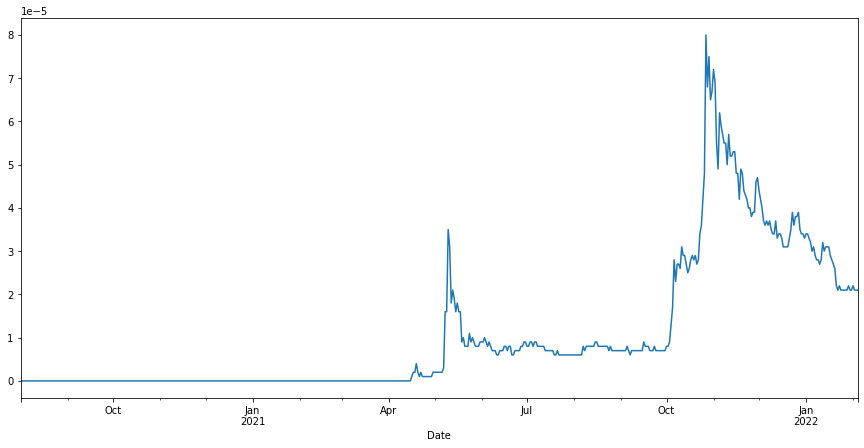

In [4]:
df = df.resample('D').ffill()
df.Close.plot(figsize=(15, 7))

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 553 entries, 2020-08-01 to 2022-02-04
Freq: D
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         553 non-null    datetime64[ns]
 1   Open                         553 non-null    float64       
 2   High                         553 non-null    float64       
 3   Low                          553 non-null    float64       
 4   Close                        553 non-null    float64       
 5   Adj Close                    553 non-null    float64       
 6   Volume                       553 non-null    int64         
 7   reddit_average_posts_48h     553 non-null    float64       
 8   reddit_average_comments_48h  553 non-null    float64       
 9   reddit_subscribers           553 non-null    float64       
 10  reddit_accounts_active_48h   553 non-null    float64       
 11  shiba inu coin_uns

In [6]:
from python_scripts.sarima_helper import create_lagged_value_columns

df.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low", "Volume", "Open", "reddit_average_posts_48h",
                "reddit_average_comments_48h", "reddit_subscribers", "reddit_accounts_active_48h",
                'shiba inu coin_unscaled', 'shiba inu coin_monthly', 'scale', 'shiba inu coin']
windows = [3,7,14,21,30,60]
df = create_lagged_value_columns(lag_features, windows, df)


In [7]:
df.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 553 entries, 2020-08-01 to 2022-02-04
Data columns (total 87 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Date                                    553 non-null    datetime64[ns]
 1   Open                                    553 non-null    float64       
 2   High                                    553 non-null    float64       
 3   Low                                     553 non-null    float64       
 4   Close                                   553 non-null    float64       
 5   Adj Close                               553 non-null    float64       
 6   Volume                                  553 non-null    int64         
 7   reddit_average_posts_48h                553 non-null    float64       
 8   reddit_average_comments_48h             553 non-null    float64       
 9   reddit_subscribers                 

In [8]:
testNum = round(df.shape[0] * 0.3)
train = df.iloc[:-testNum]
test = df.iloc[-testNum:]


In [9]:
df.isna().sum(axis = 0)
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume,reddit_average_posts_48h,reddit_average_comments_48h,reddit_subscribers,...,Volume_mean_lag60,Open_mean_lag60,reddit_average_posts_48h_mean_lag60,reddit_average_comments_48h_mean_lag60,reddit_subscribers_mean_lag60,reddit_accounts_active_48h_mean_lag60,shiba inu coin_unscaled_mean_lag60,shiba inu coin_monthly_mean_lag60,scale_mean_lag60,shiba inu coin_mean_lag60
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-01,2020-08-01,0.0,0.0,0.0,0.0,0.0,1604789,0.0,0.0,0.000000,...,1.104775e+09,0.000008,4.276187,408.573763,106012.228195,1082.93958,28.515213,8.070994,0.08071,3.959655
2020-08-02,2020-08-02,0.0,0.0,0.0,0.0,0.0,193098,0.0,0.0,13.559829,...,1.104775e+09,0.000008,4.276187,408.573763,106012.228195,1082.93958,28.515213,8.070994,0.08071,3.959655
2020-08-03,2020-08-03,0.0,0.0,0.0,0.0,0.0,129225,0.0,0.0,27.119658,...,1.104775e+09,0.000008,4.276187,408.573763,106012.228195,1082.93958,28.515213,8.070994,0.08071,3.959655
2020-08-04,2020-08-04,0.0,0.0,0.0,0.0,0.0,19717,0.0,0.0,40.679487,...,1.104775e+09,0.000008,4.276187,408.573763,106012.228195,1082.93958,28.515213,8.070994,0.08071,3.959655
2020-08-05,2020-08-05,0.0,0.0,0.0,0.0,0.0,26869,0.0,0.0,54.239316,...,1.104775e+09,0.000008,4.276187,408.573763,106012.228195,1082.93958,28.515213,8.070994,0.08071,3.959655


In [10]:
df.tail()


,Date,Open,High,Low,Close,Adj Close,Volume,reddit_average_posts_48h,reddit_average_comments_48h,reddit_subscribers,...,Volume_mean_lag60,Open_mean_lag60,reddit_average_posts_48h_mean_lag60,reddit_average_comments_48h_mean_lag60,reddit_subscribers_mean_lag60,reddit_accounts_active_48h_mean_lag60,shiba inu coin_unscaled_mean_lag60,shiba inu coin_monthly_mean_lag60,scale_mean_lag60,shiba inu coin_mean_lag60
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-31,2022-01-31,0.000021,0.000022,0.000020,0.000021,0.000021,531285879,6.182,586.182,463670.0,...,2.042872e+09,0.000044,5.818,1205.273,444346.0,1589.833333,89.0,17.0,0.17,15.13
2022-02-01,2022-02-01,0.000021,0.000022,0.000021,0.000022,0.000022,519254046,6.800,475.700,463832.0,...,2.740978e+09,0.000042,6.500,1052.000,444933.0,1417.769231,79.0,17.0,0.17,13.43
2022-02-02,2022-02-02,0.000022,0.000022,0.000020,0.000021,0.000021,484518640,7.889,499.667,463900.0,...,3.873494e+09,0.000041,6.182,1059.273,445565.0,1547.583333,81.0,17.0,0.17,13.77
2022-02-03,2022-02-03,0.000021,0.000021,0.000020,0.000021,0.000021,421850042,8.889,652.556,464046.0,...,2.307805e+09,0.000036,5.750,1049.250,446077.0,1586.769231,75.0,12.0,0.12,9.00
2022-02-04,2022-02-04,0.000021,0.000022,0.000021,0.000021,0.000021,476443712,7.000,412.667,464142.0,...,2.321210e+09,0.000036,5.917,890.167,446692.0,1459.153846,89.0,12.0,0.12,10.68


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-8152.926, Time=2.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-8152.728, Time=1.19 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-8158.307, Time=1.30 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-8153.747, Time=1.53 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-7032.669, Time=1.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-8156.868, Time=1.65 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-8156.808, Time=1.68 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-8154.881, Time=1.72 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-8160.306, Time=1.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-8158.867, Time=1.46 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-8158.809, Time=1.51 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-8155.746, Time=1.39 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-8156.882, Time=1.60 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 19.546 seconds
MAPE for

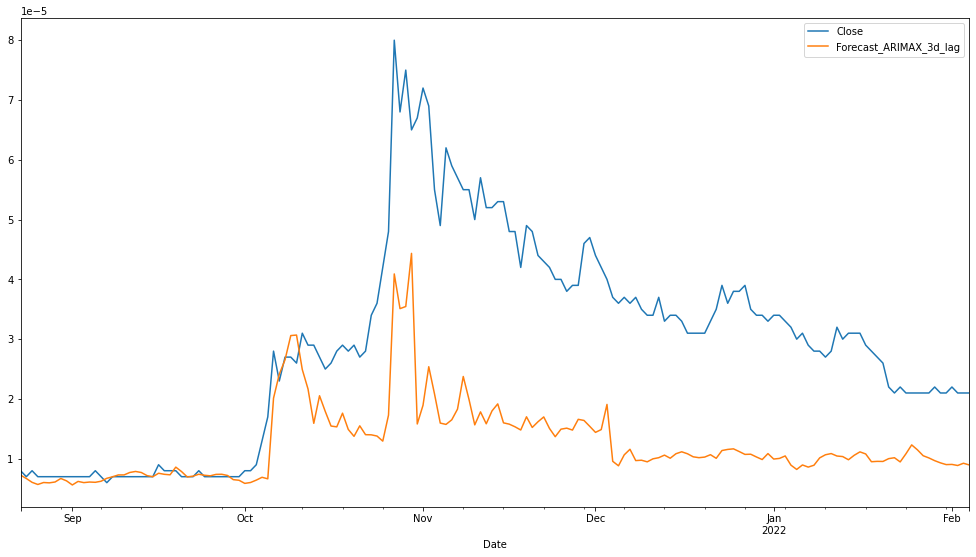

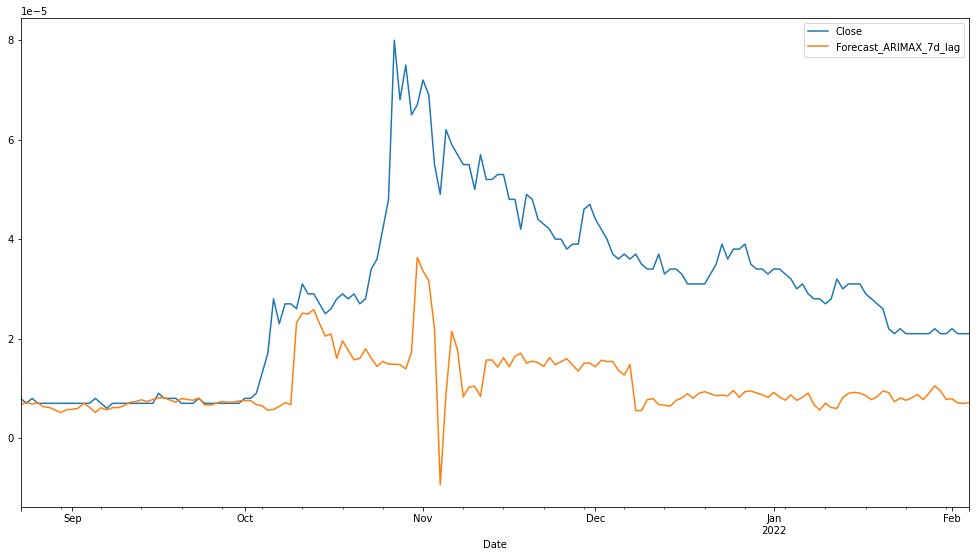

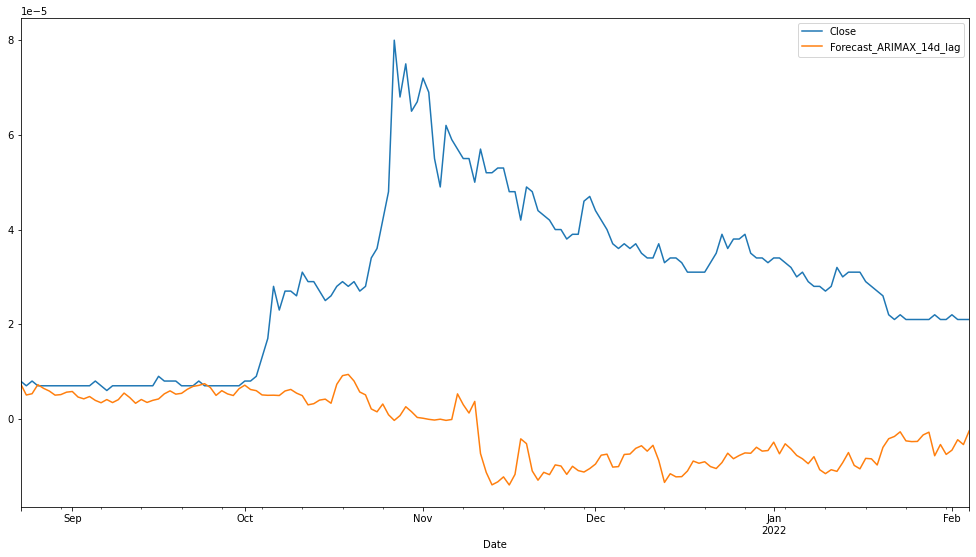

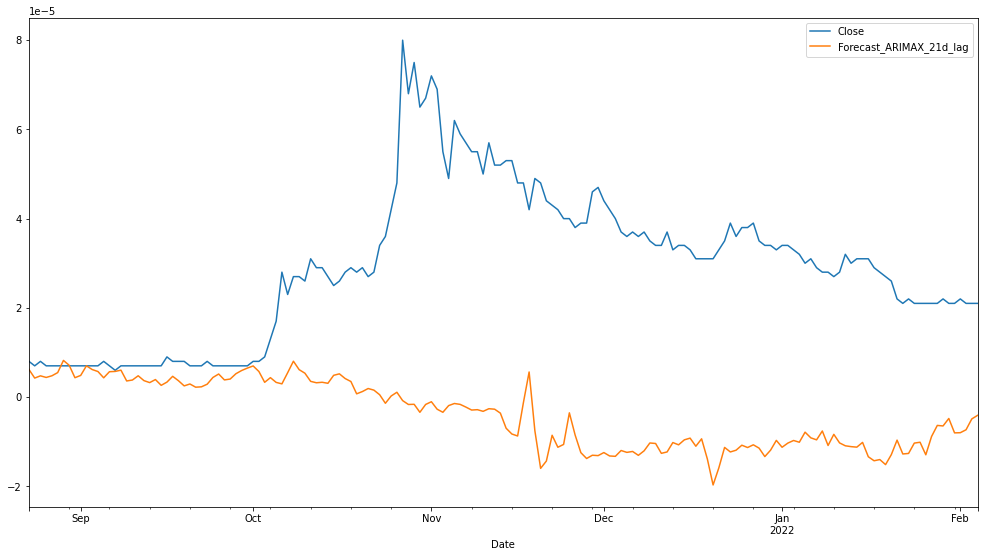

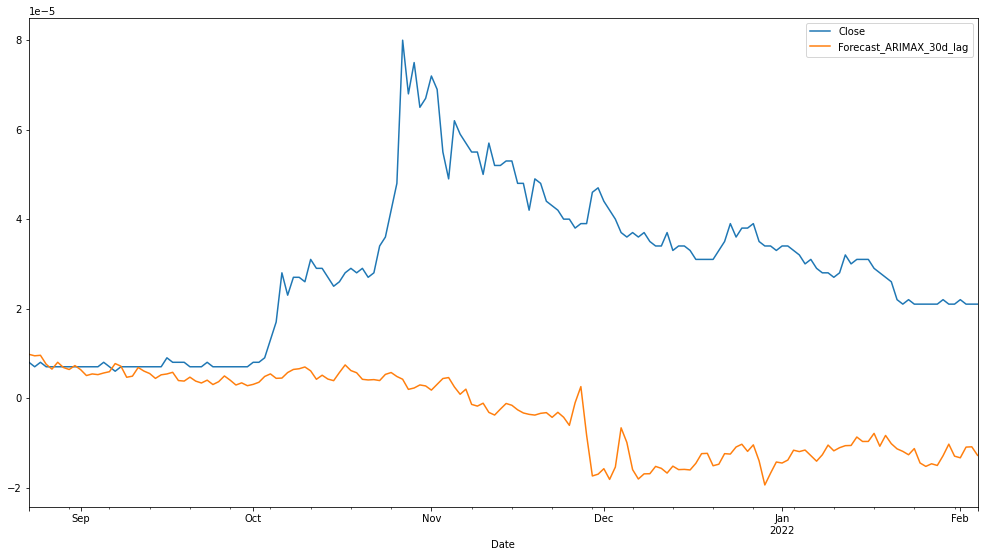

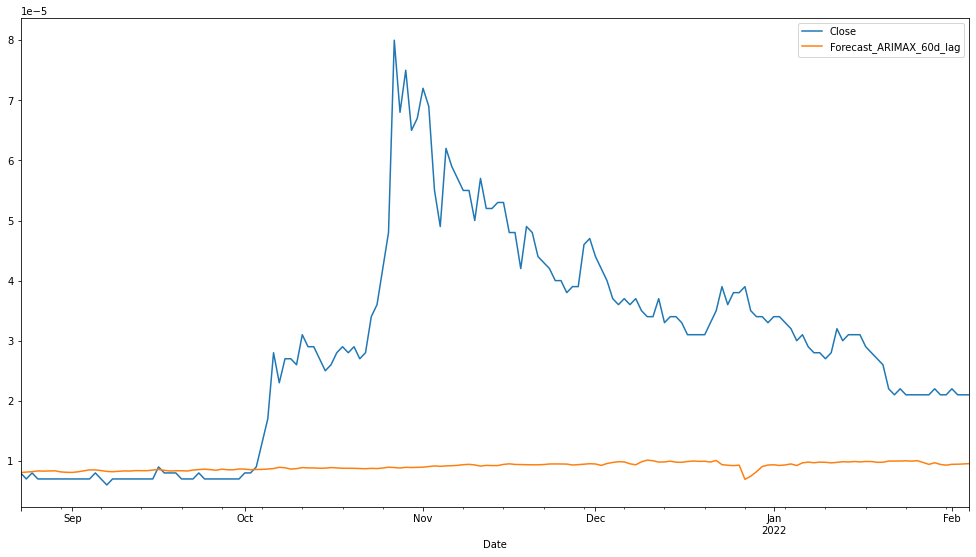

In [11]:
from python_scripts.sarima_helper import predict_with_windows

predict_with_windows(windows, train, test, lag_features)

In [12]:
#Povecavam trening skup na 90% da uhvatim poslednju Vajkof distribuciju u uzorku
testNum = round(df.shape[0] * 0.1)
train = df.iloc[:-testNum]
test = df.iloc[-testNum:]



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-10486.801, Time=2.65 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-10473.585, Time=1.47 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-10491.894, Time=1.61 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-10487.286, Time=1.96 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-8576.118, Time=1.34 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-10490.423, Time=1.94 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-10490.279, Time=1.92 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-10488.225, Time=2.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-10493.897, Time=1.44 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-10492.427, Time=1.75 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-10492.286, Time=1.80 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-10489.289, Time=1.65 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-10490.280, Time=1.94 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 23.581 seco

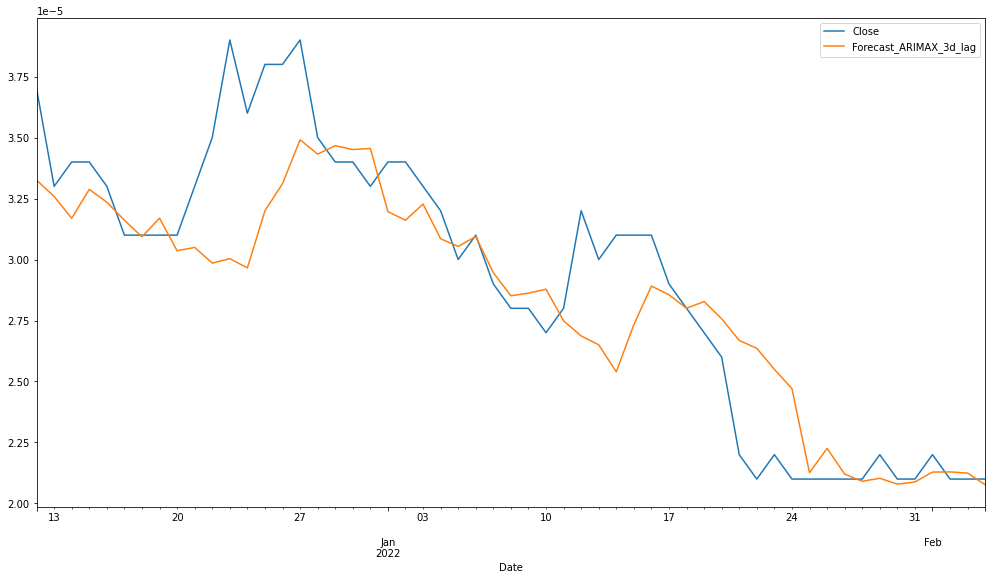

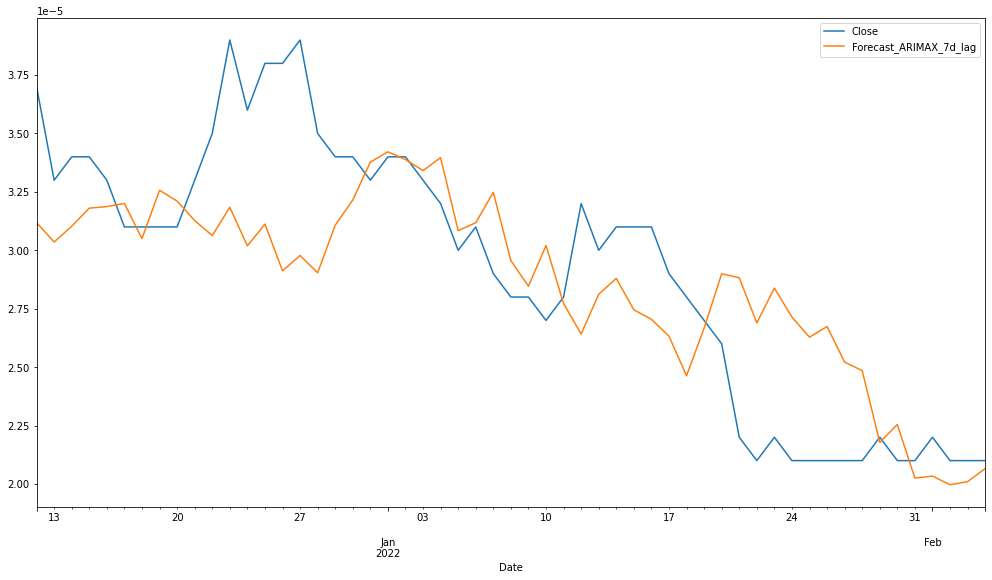

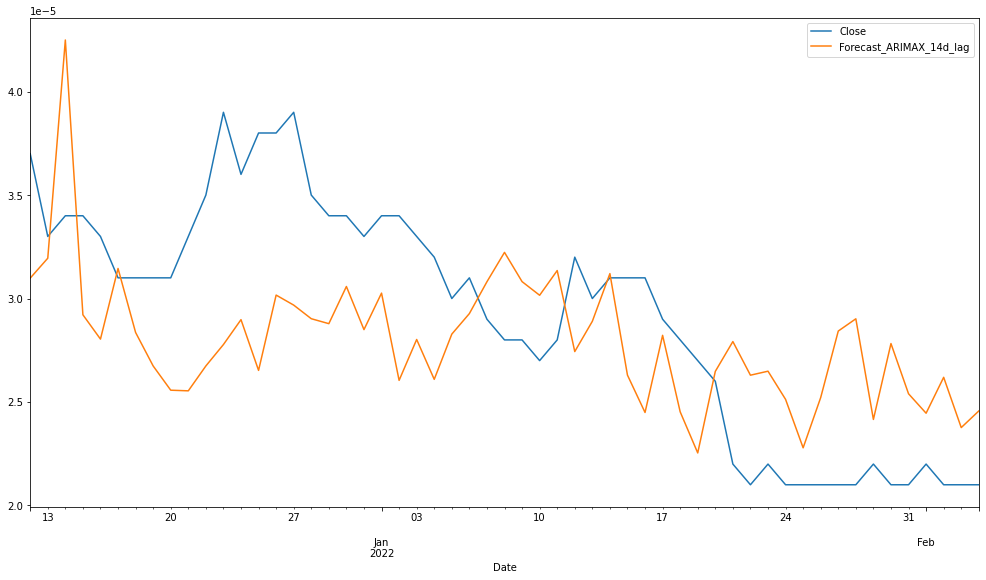

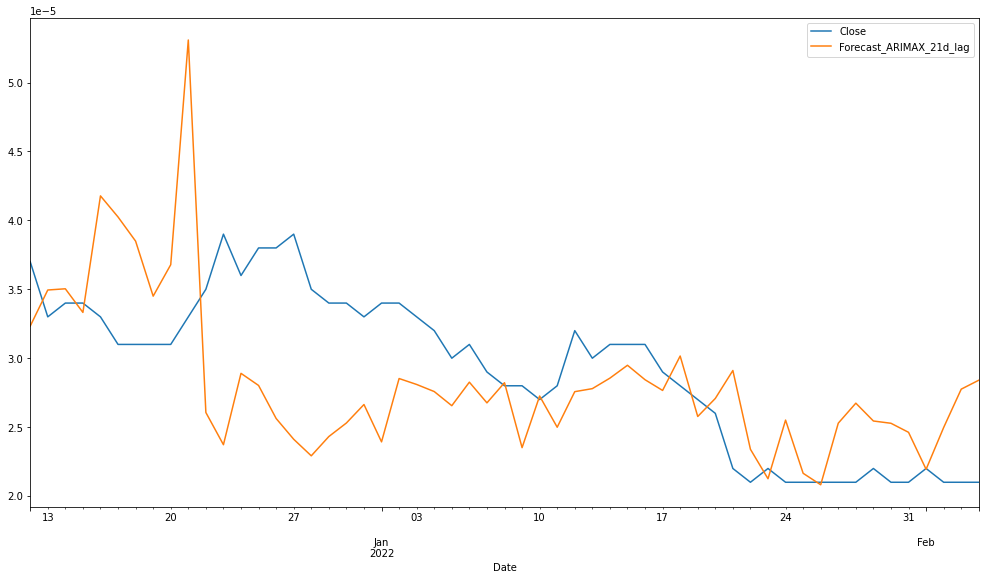

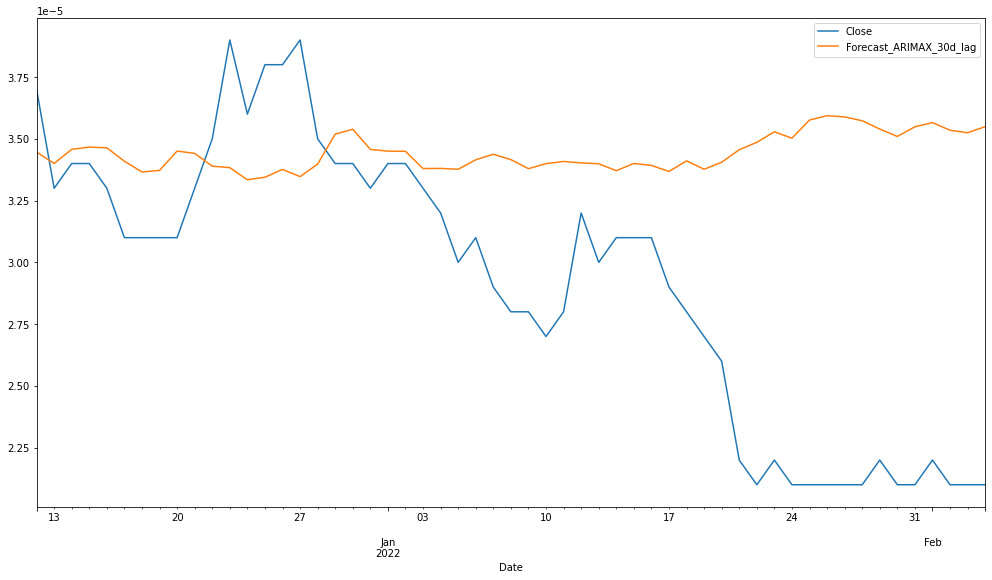

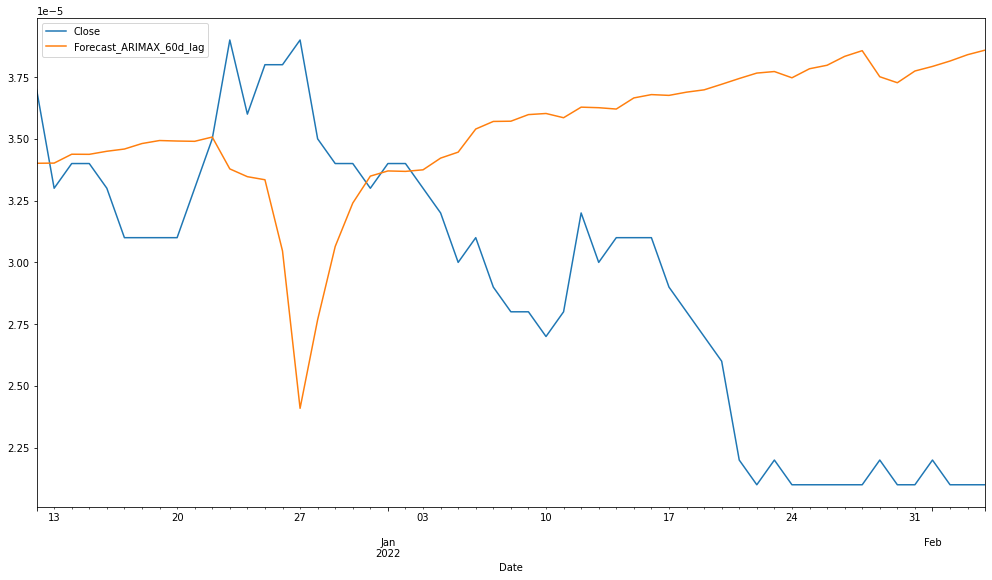

In [13]:
predict_with_windows(windows, train, test, lag_features)

In [14]:
df = pd.read_csv('../shiba_v2.csv', parse_dates=['Date'], date_parser=dateparse)
df.set_index(["Date"], drop=False, inplace=True)
df.head()

,Date,High,Close,Volume,reddit_average_posts_48h,reddit_average_comments_48h,reddit_subscribers,reddit_accounts_active_48h,shiba inu coin_monthly,shiba inu coin
Date,,,,,,,,,,
2020-08-01,2020-08-01,0.0,0.0,1604789,0.0,0.0,0.000000,0.000000,0.0,0.0
2020-08-02,2020-08-02,0.0,0.0,193098,0.0,0.0,13.559829,0.217949,0.0,0.0
2020-08-03,2020-08-03,0.0,0.0,129225,0.0,0.0,27.119658,0.435897,0.0,0.0
2020-08-04,2020-08-04,0.0,0.0,19717,0.0,0.0,40.679487,0.653846,0.0,0.0
2020-08-05,2020-08-05,0.0,0.0,26869,0.0,0.0,54.239316,0.871795,0.0,0.0


In [16]:
df.isna().sum(axis = 0)

Date                           0
High                           0
Close                          0
Volume                         0
reddit_average_posts_48h       0
reddit_average_comments_48h    0
reddit_subscribers             0
reddit_accounts_active_48h     0
shiba inu coin_monthly         0
shiba inu coin                 0
dtype: int64

In [18]:
df.reset_index(drop=True, inplace=True)
lag_features = ["High", "Volume", "reddit_average_posts_48h",
                "reddit_average_comments_48h", "reddit_subscribers", "reddit_accounts_active_48h",
                'shiba inu coin_monthly', 'shiba inu coin']
windows = [3,7,14,21,30,60]
df = create_lagged_value_columns(lag_features, windows, df)

In [19]:
testNum = round(df.shape[0] * 0.3)
train = df.iloc[:-testNum]
test = df.iloc[-testNum:]


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-8160.948, Time=2.48 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-8160.716, Time=1.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-8166.281, Time=1.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-8161.705, Time=1.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-7040.226, Time=0.80 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-8164.846, Time=1.25 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-8164.788, Time=1.29 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-8162.861, Time=1.39 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-8168.279, Time=0.89 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-8166.842, Time=1.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-8166.787, Time=1.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-8163.696, Time=1.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-8164.859, Time=1.26 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 16.222 seconds
MAPE for

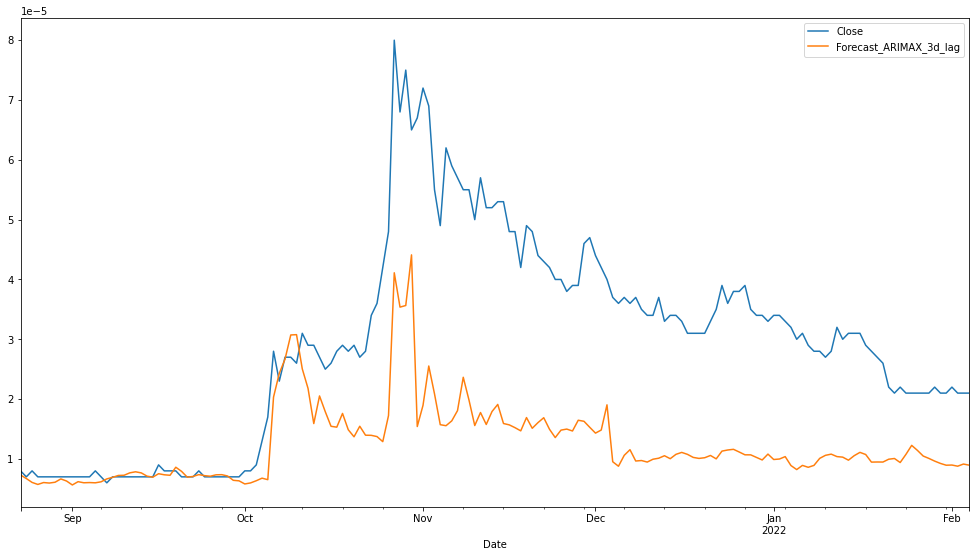

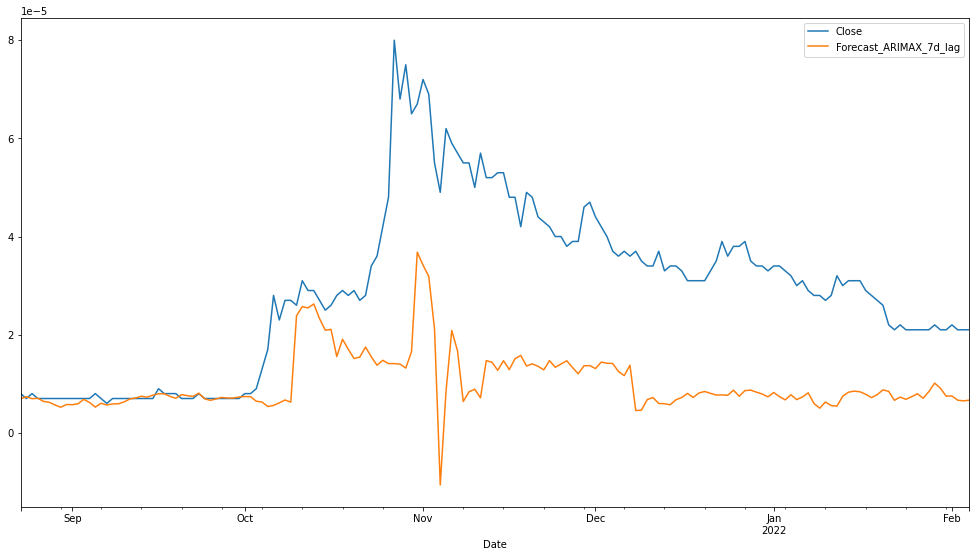

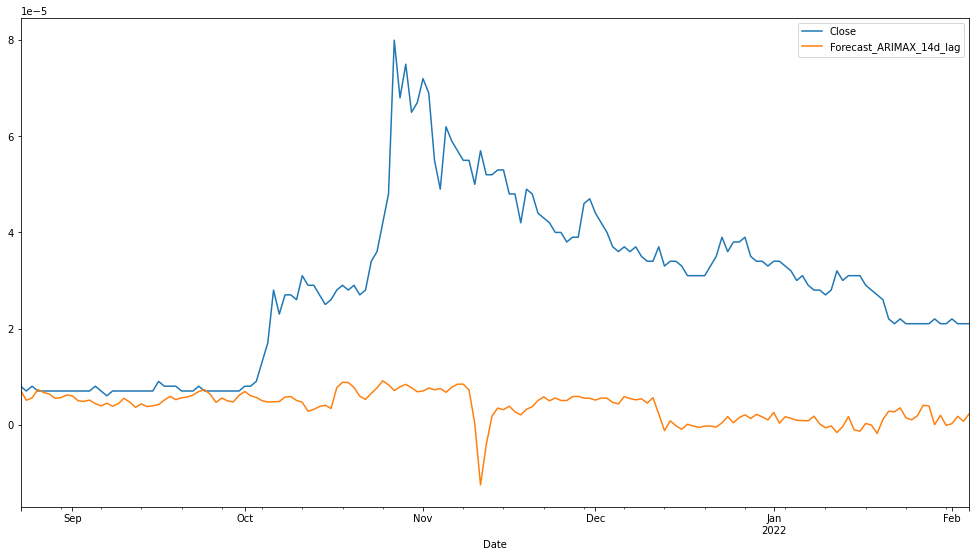

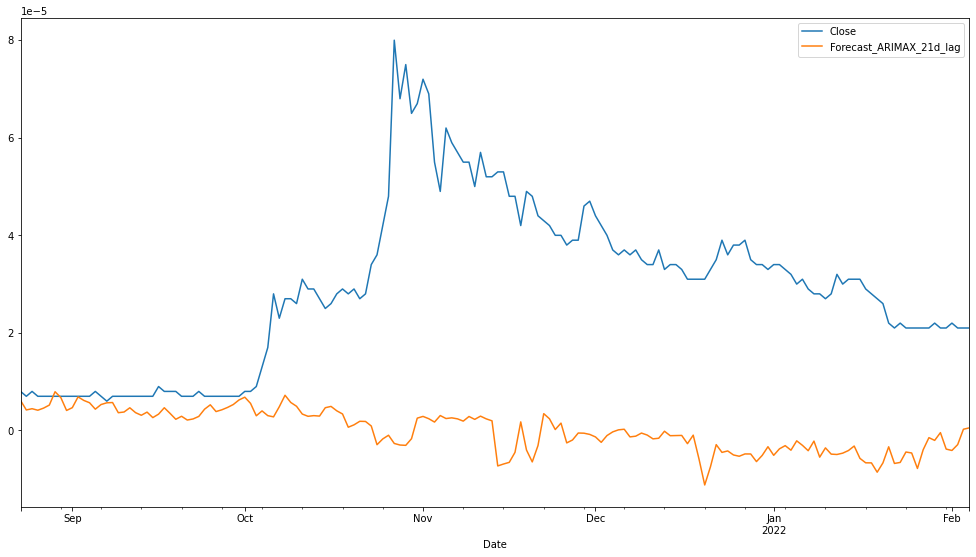

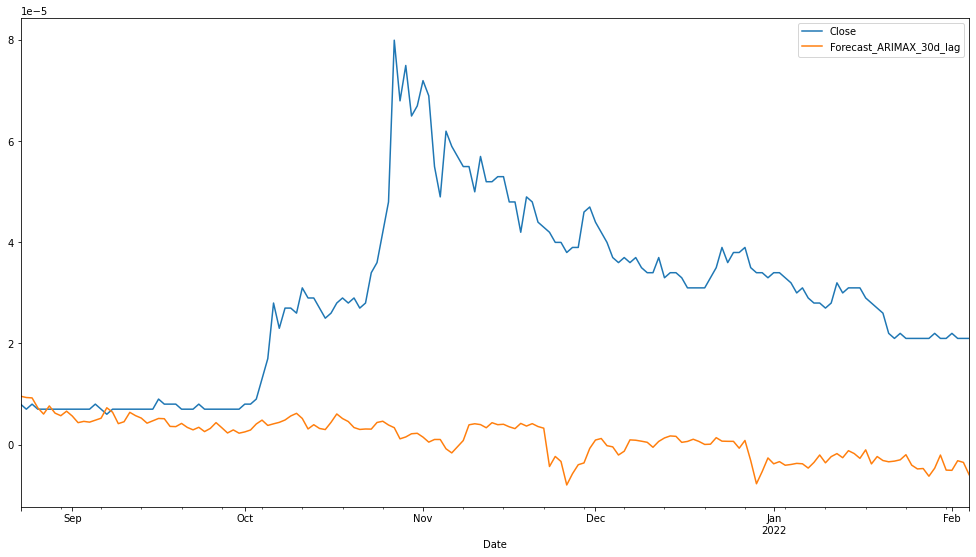

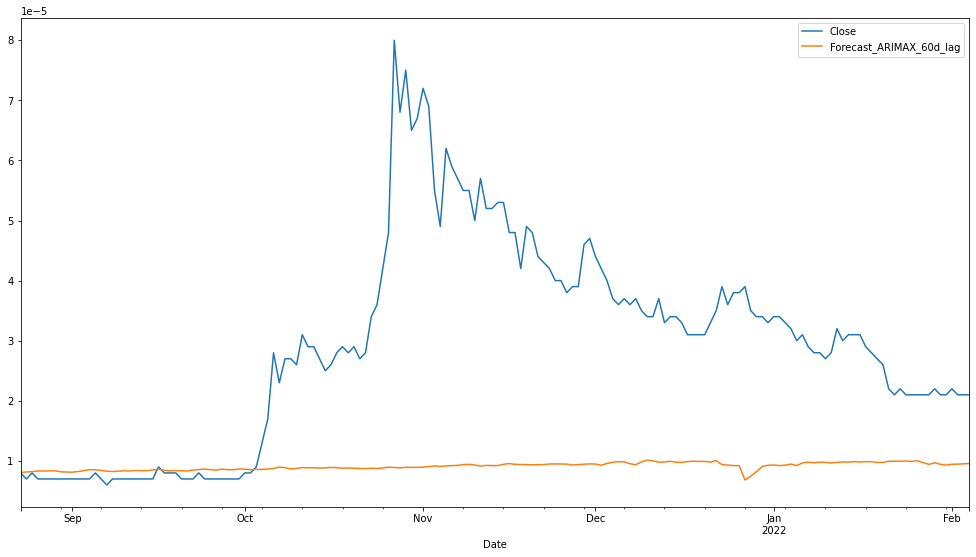

In [20]:
predict_with_windows(windows, train, test, lag_features)


In [21]:
testNum = round(df.shape[0] * 0.1)
train = df.iloc[:-testNum]
test = df.iloc[-testNum:]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-10493.279, Time=3.42 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-10482.181, Time=1.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-10498.208, Time=1.26 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-10492.102, Time=1.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-8590.024, Time=1.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-10496.323, Time=1.57 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-10496.264, Time=1.56 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-10476.164, Time=1.65 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-10500.209, Time=1.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-10498.326, Time=1.37 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-10498.270, Time=1.41 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-10494.104, Time=1.27 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-10478.170, Time=1.54 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 19.768 seco

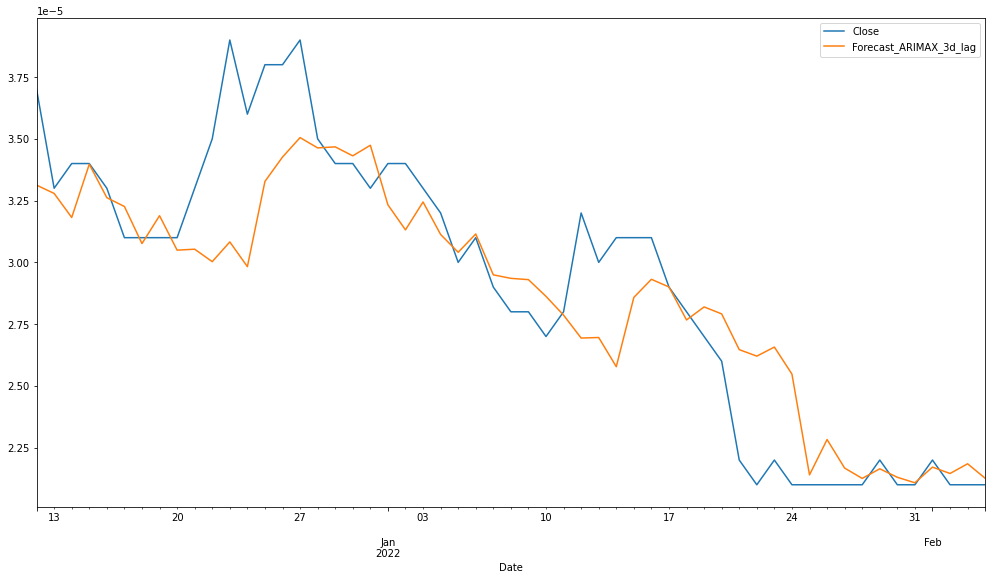

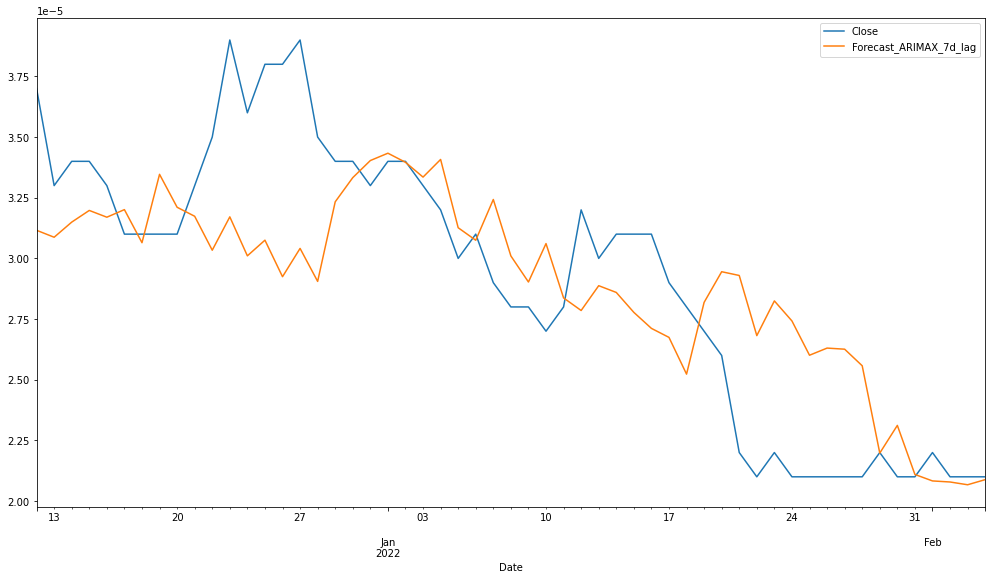

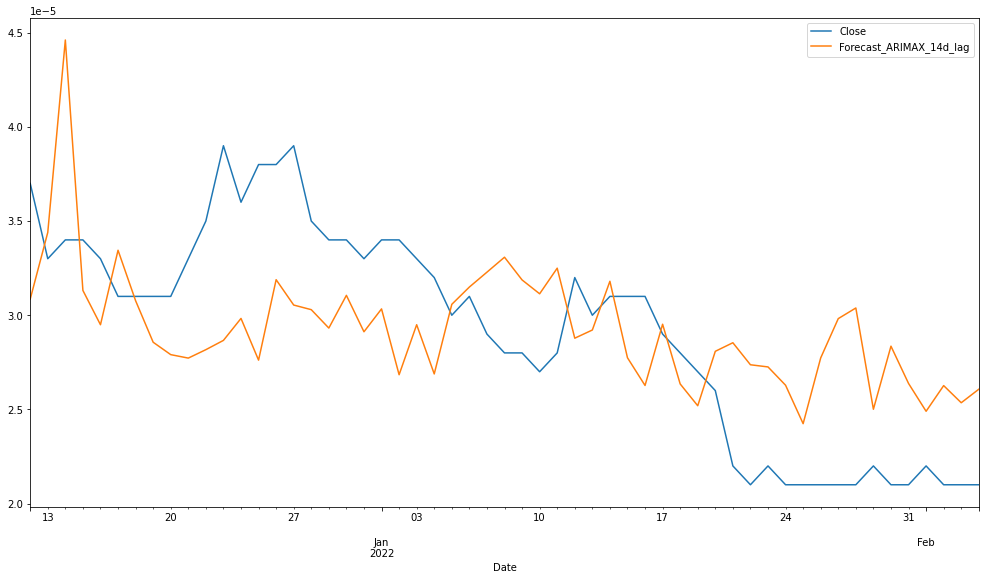

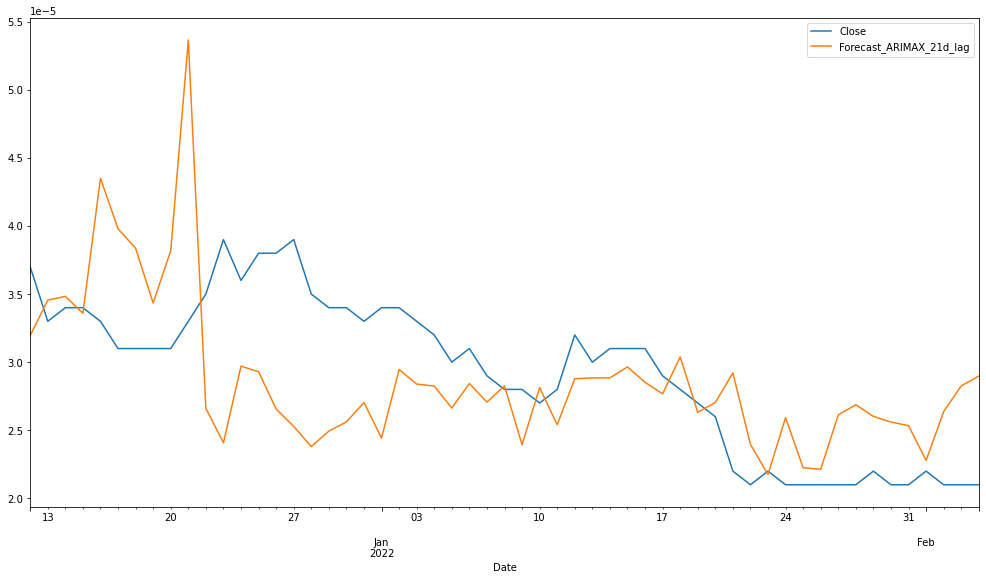

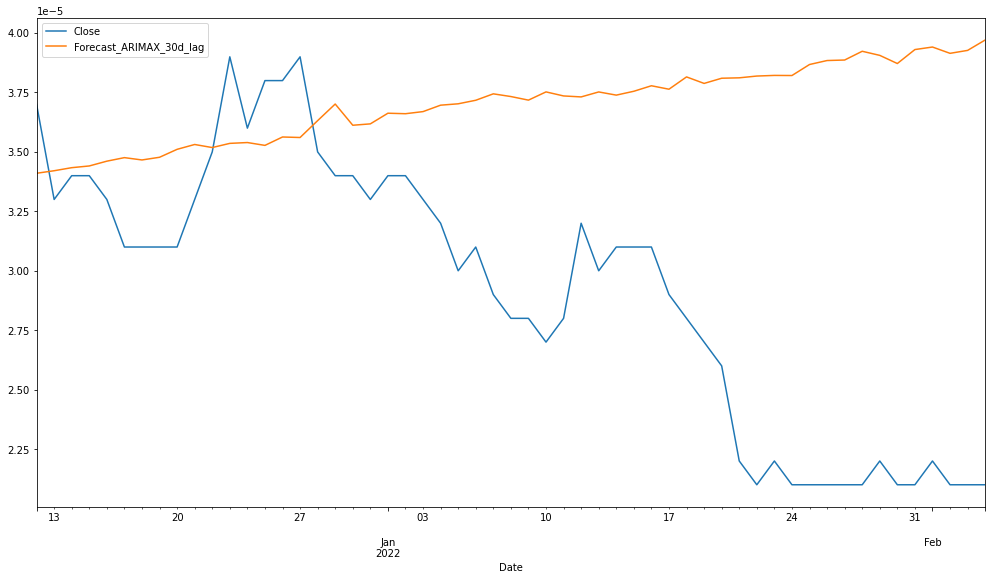

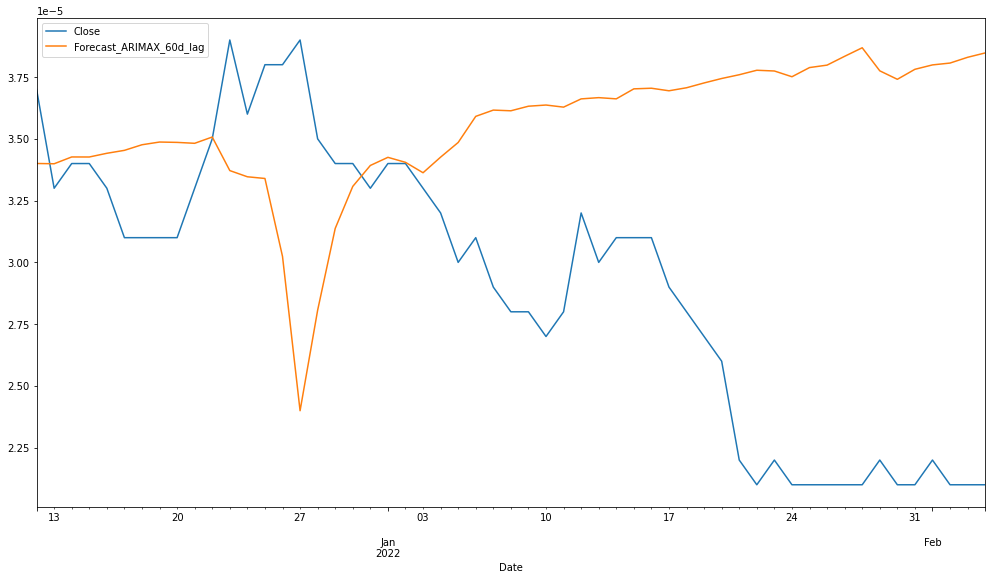

In [22]:
predict_with_windows(windows, train, test, lag_features)